### Imports

In [22]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
from sklearn.datasets import fetch_openml

# Download the MNIST dataset 
mnist = fetch_openml('mnist_784', as_frame=False)

In [9]:
X, y = mnist.data, mnist.target

print(X.shape, y.shape)

(70000, 784) (70000,)


6


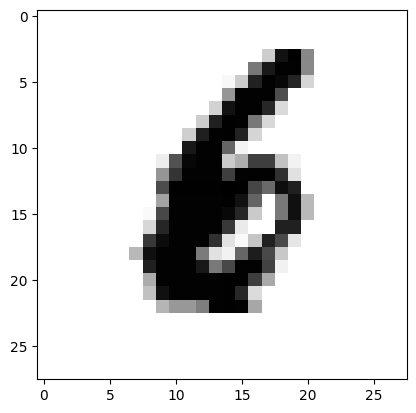

In [38]:
# Lets visualize a digit from our dataset
def show_image(img: np.array, dim: int = 28) -> None:
    """
    Takes a array of pixels, then plots a visual representation of that image
    
    Args:
        img: list: an array that represents the pixel values of an image
        dim: int: the dimension of the image
    """
    
    visual = img.reshape(dim, dim)
    plt.imshow(visual, cmap='binary')
    plt.show()


random_img = X[129]
print(y[129])
show_image(random_img)


Before we continue it is important that we set aside a test set


_The data is already shuffled. Therefore, we can simply split the data at any index_

In [40]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before anything, lets experiment with only the digit 5

In [55]:
y_train_5 = y_train == '5'
y_test_5 = y_test == '5'

In [49]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

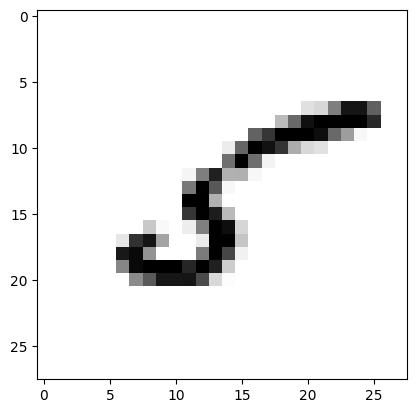

array([ True])

In [62]:
show_image(X[11])

sgd_clf.predict([X[11]])

You've got a running model. But, does it perform well? This is the tricky part. Lets first apply cross validation to see how our performance holds over different folds.


In [63]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])